# Modelling

Feature engineering, model training, tuning, selection and explanability.

# 0. Load Packages and Define Helper Functions

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from preprocessing import preprocess_df, clean_amenities
random_state = 42

import warnings
warnings.filterwarnings('ignore')

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor


from lightgbm import LGBMRegressor
from lightgbm import plot_importance
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.ensemble import StackingRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder, RobustScaler, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display="diagram")

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
from sklearn.metrics import mean_squared_error
from keras import backend
import shap
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

In [41]:
def fit_and_score(model, X_train, X_test, y_train, y_test):
    
    model.fit(X_train, y_train)
    
    # Train metrics
    pred_train= model.predict(X_train)
    train_MSE = mean_squared_error(y_train, pred_train)
    
    # Cross validated metrics
    cv_score = cross_validate(model, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'],n_jobs=2, verbose=1, cv = 5) 
    
    # Test metrics
    pred_test= model.predict(X_test)
    test_MSE = mean_squared_error(y_test, pred_test)
    
    print('Train R-sq', round(model.score(X_train, y_train),4))
    print('Train MSE:', round(train_MSE,4))
    print('')
    print('CV R-sq', round(np.mean(cv_score['test_r2']),4))
    print('CV MSE:', round(-np.mean(cv_score['test_neg_mean_squared_error']),4))
    print('')
    print('Test R-sq', round(model.score(X_test, y_test),4))
    print('Test MSE:', round(test_MSE,4))
    
    return model

def grid_search_pipe(model, grid, X_train, y_train):
    
    search = GridSearchCV(model, grid, cv=5,n_jobs=2, scoring='r2', verbose=1)
    search.fit(X_train, y_train)
    
    print("Best params:\n{}".format(search.best_params_))
    print("Best score:\n{}".format(search.best_score_)) #Mean cross-validated score of the best_estimator
    
    return search

# 1. Load and Preprocess

In [43]:
data = pd.read_csv('data/listings.csv.gz')


<AxesSubplot:>

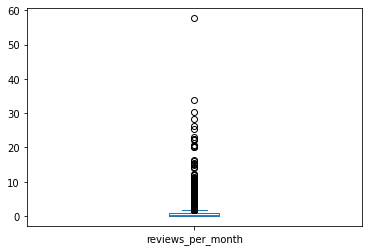

In [44]:
data['reviews_per_month'].plot(kind='box')

In [45]:
data['reviews_per_month'].describe()

count    48082.000000
mean         0.635780
std          1.037195
min          0.010000
25%          0.090000
50%          0.290000
75%          0.790000
max         57.660000
Name: reviews_per_month, dtype: float64

In [46]:
df = preprocess_df(data = data, verbose = True)

bedrooms: 368 values above cutoff, value_cutoff = 4.669999999998254
minimum_nights: 145 values above cutoff, value_cutoff = 90.0
maximum_nights: 13 values above cutoff, value_cutoff = 1125.0
minimum_nights_avg_ntm: 177 values above cutoff, value_cutoff = 90.0


In [47]:
df.columns

Index(['id', 'host_id', 'host_since', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bedrooms',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'bathroom_num', 'bathroom_sharing', 'price_log'],
      dtype='object')

In [48]:
df = clean_amenities(data = df, num_amenities =80, verbose = True)

In [49]:
df.head()

,id,host_id,host_since,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,...,amenities_central heating,amenities_outdoor dining area,amenities_cleaning before checkout,amenities_clothing storage,amenities_clothing storage: closet,amenities_mini fridge,amenities_building staff,amenities_private fenced garden or backyard,amenities_gym,amenities_children’s dinnerware
1,15400,60302,2020-03-16,0,1.0,1,1,0.0,51.48780,-0.16813,...,0,0,0,0,0,0,0,0,0,0
4,25123,103583,2020-03-15,0,3.0,1,1,0.0,51.57438,-0.21081,...,0,0,0,0,0,0,0,0,0,0
9,38610,165579,2020-08-12,1,2.0,1,1,0.0,51.50701,-0.23362,...,0,0,1,0,0,0,0,1,0,0
11,38995,167281,2020-02-21,0,1.0,1,1,0.0,51.47860,-0.06114,...,0,0,0,0,0,0,0,0,0,0
12,39387,168920,2019-11-03,0,1.0,1,0,0.0,51.52605,-0.19942,...,0,0,0,1,0,0,0,0,0,0


In [50]:
df['room_type'].value_counts()

Entire home/apt    22273
Private room       14119
Shared room          163
Hotel room           150
Name: room_type, dtype: int64

# 1. Feature Engineering

## Host Duration

In [51]:
# Last scraped date = 2021-12-07 (7th Dec)
df['host_duration'] = (pd.to_datetime('2021-12-10') - df['host_since']).dt.days

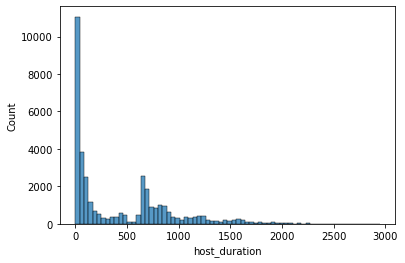

In [52]:
sns.histplot(df['host_duration'])
plt.show()

## Managed_property

In [54]:
# Understand how many properties are potentially property managed

percentiles=[0.80,0.85,0.90,0.95]
percentile_rooms=[]
room_above=[]

for p in percentiles:
   percentile_rooms.append(df.host_id.value_counts().quantile(p))

print('Understand managed property percentiles beyond P75\n')
print(pd.DataFrame({'percentile':percentiles,'rooms_threshold':percentile_rooms}))

property_count=pd.DataFrame(df.groupby(['host_id'])['host_id'].count())
property_count.columns=['properties']
property_count

Understand managed property percentiles beyond P75

   percentile  rooms_threshold
0        0.80              1.0
1        0.85              2.0
2        0.90              2.0
3        0.95              3.0


,properties
host_id,
4775,7
5653,1
6774,3
9323,1
10657,2
...,...
433334823,1
433435234,2
433572694,1


In [55]:
property_count['prop_managed']=property_count['properties'].map(lambda x: 1 if x>=percentile_rooms[3] else 0)
df=pd.merge(df,property_count,on='host_id',how='inner')
df.prop_managed.value_counts()

0    25508
1    11197
Name: prop_managed, dtype: int64

## Occupancy Rate

In [57]:
cols=['availability_30','availability_60', 'availability_90','availability_365']
df[cols].describe()

,availability_30,availability_60,availability_90,availability_365
count,36705.000000,36705.000000,36705.000000,36705.000000
mean,6.451819,17.362730,29.587985,113.895273
std,9.166336,20.781427,33.256069,133.304336
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.000000,9.000000,52.000000
75%,11.000000,36.000000,64.000000,231.000000
max,30.000000,60.000000,90.000000,365.000000


In [58]:
df['occ_30D']=1-round(df.availability_30/30,2)
df['occ_6090D']=((1-round(df.availability_60/60,2))+(1-round(df.availability_90/90,2)))/2
df['occ_365']=1-round(df.availability_365/365,2)

df=df.drop(cols,axis=1) # do not drop

In [59]:
df.columns

Index(['id', 'host_id', 'host_since', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude',
       'longitude',
       ...
       'amenities_building staff',
       'amenities_private fenced garden or backyard', 'amenities_gym',
       'amenities_children’s dinnerware', 'host_duration', 'properties',
       'prop_managed', 'occ_30D', 'occ_6090D', 'occ_365'],
      dtype='object', length=123)

## Location Variables

In [61]:
# Load computed location features
location_features = ['station', 'station_dist','walking_distance']
df = df.merge(pd.read_csv('computed_features/london_nearest_tube.csv')[['id']+location_features],left_on='id', right_on='id',how='left')
df.head()

,id,host_id,host_since,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,...,amenities_children’s dinnerware,host_duration,properties,prop_managed,occ_30D,occ_6090D,occ_365,station,station_dist,walking_distance
0,15400,60302,2020-03-16,0,1.0,1,1,0.0,51.48780,-0.16813,...,0,634,1,0,1.0,1.000,0.99,South Kensington,805.406363,0.0
1,25123,103583,2020-03-15,0,3.0,1,1,0.0,51.57438,-0.21081,...,0,635,3,1,1.0,1.000,1.00,Brent Cross,302.665825,1.0
2,41311,103583,2020-01-18,0,3.0,1,1,0.0,51.57400,-0.21058,...,0,692,3,1,0.9,0.960,0.99,Brent Cross,346.564965,1.0
3,19516454,103583,2020-03-20,0,3.0,1,1,0.0,51.57466,-0.20916,...,0,630,3,1,1.0,1.000,1.00,Brent Cross,361.025714,1.0
4,38610,165579,2020-08-12,1,2.0,1,1,0.0,51.50701,-0.23362,...,0,485,1,0,0.8,0.335,0.07,Shepherds Bush Market,449.743591,3.0


## Sentiment

In [62]:
import pandas as pd
df_sentiment = pd.read_csv('computed_features/nc_eng_with_sent.csv')

df=pd.merge(df,df_sentiment,left_on='id', right_on='listing_id',how='left')
df = df.drop(['listing_id'], axis = 1)
df = df.fillna(df.mean())
df.head()

,id_x,host_id,host_since,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,...,walking_distance,Unnamed: 0,id_y,reviewer_id,comments_len,key_reviewer,negative,neutral,positive,compound
0,15400,60302,2020-03-16,0,1.0,1,1,0.0,51.48780,-0.16813,...,0.0,1.0,8.029375e+07,2.695406e+07,78.062500,0.075000,0.016000,0.682400,0.301550,0.900261
1,25123,103583,2020-03-15,0,3.0,1,1,0.0,51.57438,-0.21081,...,1.0,3.0,8.898858e+07,3.434179e+07,61.970588,0.127451,0.011020,0.607324,0.381667,0.941062
2,41311,103583,2020-01-18,0,3.0,1,1,0.0,51.57400,-0.21058,...,1.0,10.0,1.066726e+08,3.536433e+07,71.552239,0.074627,0.007433,0.627463,0.365134,0.961803
3,19516454,103583,2020-03-20,0,3.0,1,1,0.0,51.57466,-0.20916,...,1.0,16621.0,4.596262e+08,1.034197e+08,44.500000,0.136364,0.003682,0.558909,0.437409,0.953786
4,38610,165579,2020-08-12,1,2.0,1,1,0.0,51.50701,-0.23362,...,3.0,7.0,3.235218e+08,8.901368e+07,86.068966,0.000000,0.007931,0.707483,0.284621,0.927310


In [63]:
df['x'] = np.cos(df['latitude']) * np.cos(df['longitude'])
df['y'] = np.cos(df['latitude']) * np.sin(df['longitude'])
df['z'] = np.sin(df['latitude'])

df.drop(['latitude', 'longitude'], axis = 1, inplace = True)
df

,id_x,host_id,host_since,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,property_type,room_type,...,reviewer_id,comments_len,key_reviewer,negative,neutral,positive,compound,x,y,z
0,15400,60302,2020-03-16,0,1.0,1,1,0.0,Entire rental unit,Entire home/apt,...,2.695406e+07,78.062500,0.075000,0.016000,0.682400,0.301550,0.900261,0.336654,-0.057141,0.939893
1,25123,103583,2020-03-15,0,3.0,1,1,0.0,Private room in residential home,Private room,...,3.434179e+07,61.970588,0.127451,0.011020,0.607324,0.381667,0.941062,0.253183,-0.054179,0.965900
2,41311,103583,2020-01-18,0,3.0,1,1,0.0,Private room in residential home,Private room,...,3.536433e+07,71.552239,0.074627,0.007433,0.627463,0.365134,0.961803,0.253554,-0.054197,0.965802
3,19516454,103583,2020-03-20,0,3.0,1,1,0.0,Private room in residential home,Private room,...,1.034197e+08,44.500000,0.136364,0.003682,0.558909,0.437409,0.953786,0.253008,-0.053705,0.965973
4,38610,165579,2020-08-12,1,2.0,1,1,0.0,Entire townhouse,Entire home/apt,...,8.901368e+07,86.068966,0.000000,0.007931,0.707483,0.284621,0.927310,0.314567,-0.074856,0.946279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36700,53606541,52745934,2021-12-03,0,2.0,1,1,0.0,Entire condominium (condo),Entire home/apt,...,2.304489e+06,42.000000,0.000000,0.000000,0.666000,0.334000,0.955800,0.312520,-0.055811,0.948270
36701,53618701,433572694,2021-12-06,0,1.0,0,1,0.0,Entire condominium (condo),Entire home/apt,...,1.201104e+08,46.173024,0.110482,0.014050,0.641245,0.344704,0.811415,0.309724,-0.085197,0.947002
36702,53629457,314377938,2021-12-04,0,0.0,1,0,0.0,Private room in rental unit,Private room,...,3.227269e+08,74.000000,1.000000,0.027000,0.819000,0.154000,0.894600,0.372747,-0.045520,0.926816
36703,53656459,50739127,2021-12-06,0,0.0,1,0,0.0,Private room in residential home,Private room,...,3.765545e+06,41.000000,0.000000,0.265000,0.735000,0.000000,-0.904800,0.204138,-0.106241,0.973160


# 2. Feature selection

In [64]:
# Format columns
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [65]:
df.columns.tolist()

['id_x',
 'host_id',
 'host_since',
 'host_is_superhost',
 'host_total_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_group_cleansed',
 'property_type',
 'room_type',
 'accommodates',
 'bedrooms',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'has_availability',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'instant_bookable',
 'reviews_per_month',
 'bathroom_num',
 'bathroom_sharing',
 'price_log',
 'amenities_wifi',
 'amenities_essentials',
 'amenities_smokealarm',
 'amenities_heating',
 'amenities_kitchen',
 'amenities_hangers',
 'amenities_longtermstaysallowed',
 'amenities_iron',
 'amenities_washer',
 'amenities_hairdryer',
 'amenities_ho

In [66]:
sentiment_features = [   'comments_len',
                         'neutral',
                         'negative',
                         'positive']

features_selected = ['host_total_listings_count',
                         'neighbourhood_group_cleansed',
                         'room_type',
                         'accommodates',
                         'bedrooms',
                         'minimum_nights',
                         'maximum_nights',
                         'minimum_nights_avg_ntm',
                         'maximum_nights_avg_ntm',
                         'number_of_reviews',
                         'number_of_reviews_ltm',
                         'number_of_reviews_l30d',
                         'review_scores_rating',
                         'review_scores_accuracy',
                         'review_scores_cleanliness',
                         'review_scores_checkin',
                         'review_scores_communication',
                         'review_scores_location',
                         'review_scores_value',
                         'reviews_per_month',
                         'bathroom_num',
                         'bathroom_sharing',
                        'amenities_wifi',
                        'amenities_essentials',
                        'amenities_smokealarm',
                        'amenities_heating',
                        'amenities_kitchen',
                        'amenities_hangers',
                        'amenities_longtermstaysallowed',
                        'amenities_iron',
                        'amenities_washer',
                        'amenities_hairdryer',
                        'amenities_hotwater',
                        'amenities_shampoo',
                        'amenities_carbonmonoxidealarm',
                        'amenities_dedicatedworkspace',
                        'amenities_dishesandsilverware',
                        'amenities_cookingbasics',
                        'amenities_refrigerator',
                        'amenities_bedlinens',
                        'amenities_tv',
                        'amenities_microwave',
                        'amenities_oven',
                        'amenities_stove',
                        'amenities_dryer',
                        'amenities_firstaidkit',
                        'amenities_fireextinguisher',
                        'amenities_coffeemaker',
                        'amenities_dishwasher',
                        'amenities_privateentrance',
                        'amenities_extrapillowsandblankets',
                        'amenities_luggagedropoffallowed',
                        'amenities_hostgreetsyou',
                        'amenities_lockbox',
                        'amenities_bathtub',
                        'amenities_elevator',
                        'amenities_freeparkingonpremises',
                        'amenities_showergel',
                        'amenities_paidparkingoffpremises',
                        'amenities_hotwaterkettle',
                        'amenities_backyard',
                        'amenities_freestreetparking',
                        'amenities_lockonbedroomdoor',
                        'amenities_cabletv',
                        'amenities_patioorbalcony',
                        'amenities_freezer',
                        'amenities_tvwithstandardcable',
                        'amenities_cleaningproducts',
                        'amenities_toaster',
                        'amenities_diningtable',
                        'amenities_wineglasses',
                        'amenities_roomdarkeningshades',
                        'amenities_bodysoap',
                        'amenities_breakfast',
                        'amenities_dryingrackforclothing',
                        'amenities_singlelevelhome',
                        'amenities_securitycamerasonproperty',
                        'amenities_conditioner',
                        'amenities_indoorfireplace',
                        'amenities_portablefans',
                        'amenities_ethernetconnection',
                        'amenities_outdoorfurniture',
                        'amenities_laundromatnearby',
                        'amenities_packnplaytravelcrib',
                        'amenities_crib',
                        'amenities_airconditioning',
                        'amenities_highchair',
                        'amenities_bakingsheet',
                        'amenities_bbqgrill',
                        'amenities_paidparkingonpremises',
                        'amenities_privatepatioorbalcony',
                        'amenities_centralheating',
                        'amenities_outdoordiningarea',
                        'amenities_childrensbooksandtoys',
                        'amenities_cleaningbeforecheckout',
                        'amenities_clothingstorage',
                        'amenities_clothingstoragecloset',
                        'amenities_minifridge',
                        'amenities_privatefencedgardenorbackyard',
                        'amenities_buildingstaff',
                         'host_duration',
                         'properties',
                         'x',
                         'y',
                         'z',
                         'occ_30D',
                         'occ_6090D',
                         'occ_365'] + location_features + sentiment_features

In [ ]:
X_train_trfm = X_train.drop(['station'],axis=1)
X_test_trfm = X_test.drop(['station'],axis=1)

X_train_trfm = pd.get_dummies(X_train_trfm, columns=['bathroom_sharing', 'room_type'])
X_test_trfm = pd.get_dummies(X_test_trfm, columns=['bathroom_sharing', 'room_type'])

In [220]:
def run_SFM_rfr(X,y,n=65):
    # Categorical features encoding    
    X = pd.get_dummies(X, columns=cat_cols)

    # Train-Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    
    feature_selector = SelectFromModel(estimator=LGBMRegressor(random_state = random_state),
                                       threshold='0.1*mean',
                                       max_features=n)

    X_train_sfm = feature_selector.fit_transform(X_train, y_train)
    X_test_sfm = feature_selector.transform(X_test)
    
    print('New shape: ',X_train_sfm.shape)
    print('Dropped ', X_train.shape[1]-X_train_sfm.shape[1], ' features')
    
    include=feature_selector.get_support()
    headers=X_train.columns

    fs=pd.DataFrame({'cols':headers,'include':include})
    filters=(fs.include==True)
    ncols=fs[filters].cols.to_list()

    X_train_sfm = pd.DataFrame(X_train_sfm, columns=ncols)
    X_test_sfm =pd.DataFrame(X_test_sfm, columns=ncols)
    
    cols = X_train_sfm.columns
    
    stdscaler = StandardScaler()
    X_train_trfm = stdscaler.fit_transform(X_train_sfm)
    X_test_trfm = stdscaler.transform(X_test_sfm)
    
    X_train_trfm = pd.DataFrame(X_train_trfm)
    X_train_trfm = X_train_trfm.set_axis(cols, axis=1, inplace=False)
    X_test_trfm = pd.DataFrame(X_test_trfm)
    X_test_trfm = X_test_trfm.set_axis(cols, axis=1, inplace=False)
    
    return X_train_trfm, X_test_trfm, y_train, y_test

In [221]:
y_variable = ['price_log']

# Set X and y features
X = df[features_selected]
X = X.drop(['station'],axis=1)
y = df[y_variable[0]].ravel()

In [222]:
# Numercial and categorical columns to process
num_cols = list(X.select_dtypes(include=np.number).columns)
cat_cols = list(set(X.columns)-set(X[num_cols].columns))

print('X shape: {}'.format(np.shape(X)))
print('y shape: {}'.format(np.shape(y)))
print(cat_cols)

X shape: (36705, 114)
y shape: (36705,)
['bathroom_sharing', 'room_type']


In [223]:
X_train, X_test, y_train, y_test = run_SFM_rfr(X,y)

New shape:  (29364, 65)
Dropped  54  features


In [224]:
# Numercial and categorical columns to process
num_cols = list(X_train.select_dtypes(include=np.number).columns)
cat_cols = list(set(X_train.columns)-set(X_train[num_cols].columns))

print('X shape: {}'.format(np.shape(X_train)))
print('y shape: {}'.format(np.shape(y_train)))
print(cat_cols)

X shape: (29364, 65)
y shape: (29364,)
[]


# 3. Models

## Additional EDA

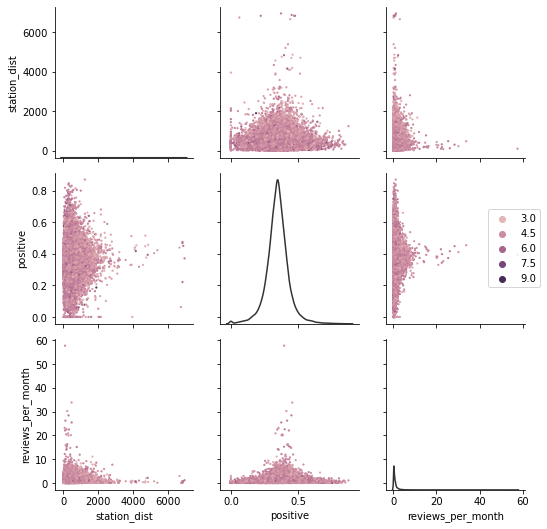

In [34]:
g = sns.PairGrid(df, vars=["station_dist", "positive", "reviews_per_month"])
g.map_diag(sns.kdeplot, color=".2")
g.map_offdiag(sns.scatterplot, hue=df["price_log"], s=5, linewidth=0)
g.axes[1, -1].legend(loc="center left", bbox_to_anchor=(.7, .5))

## Linear Regression (Baseline)

In [88]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
lr = sm.OLS(y_train,X_train)
results = lr.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     943.4
Date:                Fri, 22 Apr 2022   Prob (F-statistic):               0.00
Time:                        20:26:25   Log-Likelihood:                -18280.
No. Observations:               29364   AIC:                         3.669e+04
Df Residuals:                   29299   BIC:                         3.723e+04
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
host_total_listings_count           0.0014   3.42e-05     40.740      0.000       0.001       0.001
room_type                          -0.2056      0.006    -37.083      0.000      -0.216      -0.195
accommodates                        0.0744      0.002     30.077      0.000       0.070       0.079
bedrooms                            0.1463      0.005     27.194      0.000       0.136       0.157
minimum_nights                     -0.0025      0.001     -4.674      0.000      -0.004      -0.001
maximum_nights                  -5.393e-06   5.29e-06     -1.019      0.308   -1.58e-05    4.98e-06
minimum_nights_avg_ntm              0.0006      0.000      1.242      0.214      -0.000       0.002
maximum_nights_avg_ntm           2.093e-10   5.83e-11      3.589      0.000     9.5e-11    3.24e-10
number_of_reviews                  -0.0004   7.31e-05     -5.883      0.000      -0.001      -0.000
number_of_reviews_ltm               0.0008      0.000      2.113      0.035    6.07e-05       0.002
number_of_reviews_l30d             -0.0186      0.003     -6.696      0.000      -0.024      -0.013
review_scores_rating                0.1233      0.015      8.198      0.000       0.094       0.153
review_scores_accuracy             -0.0391      0.013     -2.985      0.003      -0.065      -0.013
review_scores_cleanliness           0.1216      0.009     12.821      0.000       0.103       0.140
review_scores_checkin              -0.0749      0.012     -6.472      0.000      -0.098      -0.052
review_scores_communication        -0.1357      0.013    -10.796      0.000      -0.160      -0.111
review_scores_location              0.2385      0.011     22.300      0.000       0.218       0.260
review_scores_value                -0.1620      0.013    -12.703      0.000      -0.187      -0.137
reviews_per_month                  -0.0006      0.004     -0.157      0.875      -0.009       0.007
bathroom_num                        0.0476      0.005      8.657      0.000       0.037       0.058
bathroom_sharing                   -0.1478      0.006    -24.820      0.000      -0.159      -0.136
amenities_wifi                      0.0381      0.019      2.030      0.042       0.001       0.075
amenities_essentials                0.0274      0.014      1.901      0.057      -0.001       0.056
amenities_iron                     -0.0452      0.008     -5.501      0.000      -0.061      -0.029
amenities_hairdryer                 0.0351      0.011      3.215      0.001       0.014       0.056
amenities_shampoo                   0.0819      0.006     12.894      0.000       0.069       0.094
amenities_carbonmonoxidealarm       0.0291      0.006      4.928      0.000       0.018       0.041
amenities_dishesandsilverware      -0.0069      0.009     -0.787      0.432      -0

In [36]:
results.mse_model

29873.054993742495

## Decision Tree (Baseline)

In [229]:
dt = DecisionTreeRegressor()

dt_model = fit_and_score(model = dt, 
                             X_train = X_train, 
                             X_test = X_test,
                             y_train = y_train,
                             y_test = y_test)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Train R-sq 1.0
Train MSE: 0.0

CV R-sq 0.479
CV MSE: 0.324

Test R-sq 0.4808
Test MSE: 0.313


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    8.0s finished


## XGB Regressor

### Tuning XGB

RandomizedSearch then GridSearch

In [38]:
xgb = XGBRegressor(random_state = random_state, use_label_encoder=False)

random_grid = {
    "xgbregressor__n_estimators": range(50, 500, 50),
    "xgbregressor__max_depth": range(2,20,2),
    'xgbregressor__subsample': np.linspace(0.3, 1, 10),
    'xgbregressor__colsample_bytree': np.linspace(0.2, 1, 5),
    'xgbregressor__reg_lambda': np.linspace(0, 5, 11),
    'xgbregressor__reg_alpha': np.linspace(0, 5, 11),
    'xgbregressor__gamma': np.linspace(0, 5, 5)
}

rsearch_xgb = RandomizedSearchCV(xgb, random_grid, cv=5,n_jobs=2, scoring='r2', n_iter = 100, verbose=1)
rsearch_xgb.fit(X_train, y_train)

print("Best params:\n{}".format(rsearch_xgb.best_params_))
print("Best score:\n{}".format(rsearch_xgb.best_score_)) 

Fitting 5 folds for each of 100 candidates, totalling 500 fits


MemoryError: Unable to allocate 3.58 MiB for an array with shape (20, 23492) and data type float64

In [ ]:
grid = {
    "xgbregressor__n_estimators": [350,400,450],
    "xgbregressor__max_depth": [6,8,10],
    'xgbregressor__subsample': [0.9],
    'xgbregressor__colsample_bytree': [0.6],
    'xgbregressor__reg_lambda': [1,2,3],
    'xgbregressor__reg_alpha': [2,3.5,4.5],
    'xgbregressor__gamma': [2,3.75]
}

gsearch_xgb = grid_search_pipe(xgb, grid, X_train, y_train)

### XGB Best

In [ ]:
xgb_best = XGBRegressor(random_state = random_state,
                        use_label_encoder=False,
                        subsample = 0.9,
                        reg_alpha = 2,
                        n_estimators = 450, 
                        max_depth = 8, 
                        gamma = 2,
                        colsample_bytree = 0.6
                        )

xgb_model = fit_and_score(model = xgb_best, 
                         X_train = X_train, 
                         X_test = X_test,
                         y_train = y_train,
                         y_test = y_test)

## LGBM Regressor

### Tuning LGBM

In [232]:
lgb = LGBMRegressor(random_state = random_state)
                    
random_grid = { 'lgbmregressor__boosting_type': ['gbdt','dart','goss'],
                'lgbmregressor__n_estimators': range(50, 500, 50),
                'lgbmregressor__max_bin':range(2, 20, 2),
                'lgbmregressor__num_leaves':range(10, 200, 10),
                'lgbmregressor__max_depth': np.arange(2,20,2).tolist(),
                'lgbmregressor__colsample_bytree' : np.linspace(0.2, 1, 5),
                'lgbmregressor__subsample' : np.linspace(0.3, 1, 10)}


rsearch_lgb = RandomizedSearchCV(lgb, random_grid, cv=5,n_jobs=2, scoring='r2', n_iter = 100, verbose=1)
rsearch_lgb.fit(X_train, y_train)

print("Best params:\n{}".format(rsearch_lgb.best_params_))
print("Best score:\n{}".format(rsearch_lgb.best_score_)) 

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best params:
{'lgbmregressor__subsample': 0.6111111111111112, 'lgbmregressor__num_leaves': 90, 'lgbmregressor__n_estimators': 50, 'lgbmregressor__max_depth': 10, 'lgbmregressor__max_bin': 6, 'lgbmregressor__colsample_bytree': 0.8, 'lgbmregressor__boosting_type': 'gbdt'}
Best score:
0.7733944100320655


In [231]:
grid= {  'lgbmregressor__boosting_type': ['gbdt'],
         'lgbmregressor__n_estimators': [250,300,350],
         'lgbmregressor__max_bin':[10],
         'lgbmregressor__num_leaves': [25,30,35],
         'lgbmregressor__max_depth': [12,14,16],
         'lgbmregressor__colsample_bytree' : [0.3,0.4,0.5],
         'lgbmregressor__subsample' : [0.50,0.55,0.60]}

gsearch_lgb = grid_search_pipe(lgb, grid, X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


KeyboardInterrupt: 

### Best LGBM

In [233]:
lgbm_best = LGBMRegressor(random_state = random_state,
                        boosting_type = 'gbdt',
                        colsample_bytree = 0.4,
                        max_bin = 10,
                        max_depth = 12,
                        n_estimators = 350,
                        num_leaves = 35,
                        subsample = 0.50)
        
lgb_model_tuned = fit_and_score(model = lgbm_best, 
                         X_train = X_train, 
                         X_test = X_test,
                         y_train = y_train,
                         y_test = y_test)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    3.3s finished


Train R-sq 0.8673
Train MSE: 0.0826

CV R-sq 0.7741
CV MSE: 0.1405

Test R-sq 0.7881
Test MSE: 0.1277


## Random Forest Regressor

### Tuning RFR

In [ ]:
rf = RandomForestRegressor(random_state = random_state)

random_grid = {'randomforestregressor__max_features':['auto','sqrt','log2'],
                'randomforestregressor__n_estimators': range(100,500,50),
                'randomforestregressor__bootstrap': [True,False],
                'randomforestregressor__oob_score':[True,False],
                'randomforestregressor__max_depth': range(2, 20, 2),
                'randomforestregressor__ccp_alpha' : np.arange(0.01, 0.30,0.02).tolist(),
              'randomforestregressor__min_samples_split' : range(1,5,1)}


rsearch_rf = RandomizedSearchCV(rf, random_grid, cv=5,n_jobs=2, scoring='r2', n_iter = 100, verbose=1)
rsearch_rf.fit(X_train, y_train)

print("Best params:\n{}".format(rsearch_rf.best_params_))
print("Best score:\n{}".format(rsearch_rf.best_score_))

In [ ]:
grid = {'randomforestregressor__max_features':['log2'],
        'randomforestregressor__n_estimators': [200, 250, 300, 350],
        'randomforestregressor__bootstrap': [True],
        'randomforestregressor__oob_score':[False],
        'randomforestregressor__max_depth': [14, 18, 22],
        'randomforestregressor__ccp_alpha' : [0.0, 0.01, 0.05],
        'randomforestregressor__min_samples_split' : [2, 3, 4]}

gsearch_rf = grid_search_pipe(rf, grid, X_train, y_train)

### Best RFR

In [ ]:
rf_best = RandomForestRegressor(random_state = random_state,
                                max_features = 'log2',
                                n_estimators = 250,
                                bootstrap = True,
                                oob_score = False,
                                max_depth = 22,
                                ccp_alpha = 0.0,
                                min_samples_split = 2
                                )

rf_model_tuned = fit_and_score(model = rf_best, 
                         X_train = X_train, 
                         X_test = X_test,
                         y_train = y_train,
                         y_test = y_test)

## Stacking Regressor

In [ ]:
estimators = [
    ("XGBoost Classifier", xgb_best),
    ("LGBM Classifier", lgbm_best),
    ("Random Forest Classifier", rf_best)
]

stacking_regressor = StackingRegressor(estimators=estimators, 
                                         final_estimator=LGBMRegressor(random_state=random_state))
stacking_regressor

In [ ]:
stacking_regressor_base = fit_and_score(model = stacking_regressor, 
                         X_train = X_train, 
                         X_test = X_test,
                         y_train = y_train,
                         y_test = y_test)

### Stacking L1 Tuning

GridSearch only

In [ ]:
# Tune LightGBM at Level 1
grid = {'final_estimator__n_estimators': [50, 100, 150, 200, 250],
               'final_estimator__max_depth': [2, 4, 6, 8, 10]}

search = grid_search_pipe(model = stacking_regressor, 
                            grid = grid, 
                            X_train = X_train, 
                            y_train = y_train) 

### Best Stacker

In [ ]:
estimators = [
    ("LGBM Classifier", lgbm_best),
    ("XGBoost Classifier", xgb_best),
    ("Random Forest Classifier", rf_best)
]

stacking_regressor_best = StackingRegressor(estimators=estimators, final_estimator=LGBMRegressor(random_state=random_state, max_depth = 4, n_estimators = 50))
stacking_regressor_best

In [ ]:
stacking_regressor_best = fit_and_score(model = stacking_regressor_best, 
                         X_train = X_train, 
                         X_test = X_test,
                         y_train = y_train,
                         y_test = y_test)

## Neural Network

In [83]:
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

def r2(y_true, y_pred):
    SS_res =  backend.sum(backend.square( y_true-y_pred )) 
    SS_tot = backend.sum(backend.square( y_true - backend.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + backend.epsilon()) )

### Baseline NN

In [225]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(65, input_dim=65, kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse,r2])
    return model
model_bl = baseline_model()
model_bl.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 65)                4290      
                                                                 
 batch_normalization_32 (Bat  (None, 65)               260       
 chNormalization)                                                
                                                                 
 activation_32 (Activation)  (None, 65)                0         
                                                                 
 dense_65 (Dense)            (None, 1)                 66        
                                                                 
Total params: 4,616
Trainable params: 4,486
Non-trainable params: 130
_________________________________________________________________


In [226]:
epoch=100
history_bl = model_bl.fit(X_train, y_train, epochs=epoch, validation_split=0.05, verbose=1)

Train on 27895 samples, validate on 1469 samples
Epoch 1/100
27895/27895 [==============================] - 2s 75us/sample - loss: 1.5487 - rmse: 0.7771 - r2: -1.7927 - val_loss: 0.2476 - val_rmse: 0.3612 - val_r2: 0.5850
Epoch 2/100
27895/27895 [==============================] - 2s 55us/sample - loss: 0.2661 - rmse: 0.3844 - r2: 0.5415 - val_loss: 0.2222 - val_rmse: 0.3491 - val_r2: 0.6129
Epoch 3/100
27895/27895 [==============================] - 2s 55us/sample - loss: 0.2343 - rmse: 0.3589 - r2: 0.5985 - val_loss: 0.2125 - val_rmse: 0.3341 - val_r2: 0.6520
Epoch 4/100
27895/27895 [==============================] - 2s 56us/sample - loss: 0.2189 - rmse: 0.3463 - r2: 0.6248 - val_loss: 0.1956 - val_rmse: 0.3178 - val_r2: 0.6758
Epoch 5/100
27895/27895 [==============================] - 2s 56us/sample - loss: 0.2070 - rmse: 0.3353 - r2: 0.6458 - val_loss: 0.2114 - val_rmse: 0.3322 - val_r2: 0.6232
Epoch 6/100
27895/27895 [==============================] - 2s 57us/sample - loss: 0.2026 -

KeyboardInterrupt: 

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scattergl(y=history_bl.history['loss'],
                    name='Train'))
fig.add_trace(go.Scattergl(y=history_bl.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, width=700,
                  xaxis_title='Epoch',
                  yaxis_title='MSE')
fig.show()

### Best Baseline NN

In [ ]:
best_model_bl = baseline_model()
best_model_bl.summary()
epoch=50
best_history_bl = best_model_bl.fit(X_train, y_train, epochs=epoch, validation_split=0.05, verbose=0)

In [228]:
from sklearn.model_selection import KFold
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)
mse_per_fold = []
r2_per_fold = []
# K-fold Cross Validation model evaluation
for train, test in kfold.split(X_train, y_train):
    X_val = X_train.iloc[test]
    y_val = y_train[test]
    # Define the model architecture
    model = baseline_model()

    # Fit data to model
    history = model.fit(X_train.iloc[train], y_train[train],
              epochs=epoch,
              verbose=0,
              validation_data=(X_val,y_val))

    # Generate generalization metrics
    mse_per_fold.append(history.history['val_loss'][epoch-1])
    r2_per_fold.append(history.history['val_r2'][epoch-1])

print('CV R-sq: ', round(np.mean(r2_per_fold),4))
print('CV MSE: ', round(np.mean(mse_per_fold),4))

Train on 23491 samples, validate on 5873 samples
Epoch 1/50
23491/23491 [==============================] - 2s 89us/sample - loss: 2.0417 - rmse: 0.9004 - r2: -2.7734 - val_loss: 0.2582 - val_rmse: 0.3525 - val_r2: 0.5509
Epoch 2/50
23491/23491 [==============================] - 2s 64us/sample - loss: 0.2771 - rmse: 0.3909 - r2: 0.5216 - val_loss: 0.2692 - val_rmse: 0.3607 - val_r2: 0.4764
Epoch 3/50
23491/23491 [==============================] - 1s 64us/sample - loss: 0.2441 - rmse: 0.3658 - r2: 0.5800 - val_loss: 0.2184 - val_rmse: 0.3316 - val_r2: 0.6110
Epoch 4/50
23491/23491 [==============================] - 2s 64us/sample - loss: 0.2315 - rmse: 0.3553 - r2: 0.4040 - val_loss: 0.2045 - val_rmse: 0.3248 - val_r2: 0.6414
Epoch 5/50
23491/23491 [==============================] - 2s 64us/sample - loss: 0.2155 - rmse: 0.3408 - r2: 0.6329 - val_loss: 0.2032 - val_rmse: 0.3200 - val_r2: 0.6237
Epoch 6/50
23491/23491 [==============================] - 1s 64us/sample - loss: 0.2122 - rmse:

23491/23491 [==============================] - 1s 64us/sample - loss: 0.1666 - rmse: 0.2962 - r2: 0.7181 - val_loss: 0.1814 - val_rmse: 0.2938 - val_r2: 0.6806
Epoch 49/50
23491/23491 [==============================] - 1s 64us/sample - loss: 0.1657 - rmse: 0.2934 - r2: 0.7184 - val_loss: 0.1786 - val_rmse: 0.2941 - val_r2: 0.6766
Epoch 50/50
23491/23491 [==============================] - 2s 65us/sample - loss: 0.1663 - rmse: 0.2938 - r2: 0.7158 - val_loss: 0.1780 - val_rmse: 0.2929 - val_r2: 0.6862
Train on 23491 samples, validate on 5873 samples
Epoch 1/50
23491/23491 [==============================] - 2s 92us/sample - loss: 1.6846 - rmse: 0.8196 - r2: -2.1816 - val_loss: 0.2613 - val_rmse: 0.3740 - val_r2: 0.5561
Epoch 2/50
23491/23491 [==============================] - 2s 65us/sample - loss: 0.2705 - rmse: 0.3879 - r2: 0.5365 - val_loss: 0.2291 - val_rmse: 0.3489 - val_r2: 0.6006
Epoch 3/50
23491/23491 [==============================] - 2s 65us/sample - loss: 0.2431 - rmse: 0.3652 -

23491/23491 [==============================] - 2s 65us/sample - loss: 0.1597 - rmse: 0.2889 - r2: 0.7302 - val_loss: 0.1779 - val_rmse: 0.3003 - val_r2: 0.6948
Epoch 46/50
23491/23491 [==============================] - 1s 63us/sample - loss: 0.1581 - rmse: 0.2887 - r2: 0.7338 - val_loss: 0.1716 - val_rmse: 0.2946 - val_r2: 0.6990
Epoch 47/50
23491/23491 [==============================] - 2s 65us/sample - loss: 0.1592 - rmse: 0.2886 - r2: 0.7311 - val_loss: 0.1760 - val_rmse: 0.2987 - val_r2: 0.6937
Epoch 48/50
23491/23491 [==============================] - 1s 64us/sample - loss: 0.1575 - rmse: 0.2875 - r2: 0.7351 - val_loss: 0.1693 - val_rmse: 0.2920 - val_r2: 0.7112
Epoch 49/50
23491/23491 [==============================] - 2s 65us/sample - loss: 0.1592 - rmse: 0.2888 - r2: 0.7275 - val_loss: 0.1709 - val_rmse: 0.2939 - val_r2: 0.7116
Epoch 50/50
23491/23491 [==============================] - 1s 64us/sample - loss: 0.1600 - rmse: 0.2892 - r2: 0.7243 - val_loss: 0.1700 - val_rmse: 0.29

23491/23491 [==============================] - 2s 66us/sample - loss: 0.1542 - rmse: 0.2881 - r2: 0.7359 - val_loss: 0.1931 - val_rmse: 0.2988 - val_r2: 0.6903
Epoch 43/50
23491/23491 [==============================] - 2s 66us/sample - loss: 0.1511 - rmse: 0.2852 - r2: 0.7082 - val_loss: 0.1909 - val_rmse: 0.2977 - val_r2: 0.6952
Epoch 44/50
23491/23491 [==============================] - 2s 65us/sample - loss: 0.1529 - rmse: 0.2863 - r2: 0.7367 - val_loss: 0.1953 - val_rmse: 0.2971 - val_r2: 0.6868
Epoch 45/50
23491/23491 [==============================] - 2s 65us/sample - loss: 0.1517 - rmse: 0.2860 - r2: 0.7361 - val_loss: 0.1943 - val_rmse: 0.2978 - val_r2: 0.6887
Epoch 46/50
23491/23491 [==============================] - 2s 64us/sample - loss: 0.1505 - rmse: 0.2846 - r2: 0.7410 - val_loss: 0.1925 - val_rmse: 0.2990 - val_r2: 0.6895
Epoch 47/50
23491/23491 [==============================] - 2s 66us/sample - loss: 0.1527 - rmse: 0.2862 - r2: 0.7388 - val_loss: 0.2056 - val_rmse: 0.31

23491/23491 [==============================] - 2s 67us/sample - loss: 0.1624 - rmse: 0.2910 - r2: 0.7276 - val_loss: 0.1735 - val_rmse: 0.2889 - val_r2: 0.7000
Epoch 40/50
23491/23491 [==============================] - 2s 66us/sample - loss: 0.1613 - rmse: 0.2902 - r2: 0.7264 - val_loss: 0.1884 - val_rmse: 0.3037 - val_r2: 0.6600
Epoch 41/50
23491/23491 [==============================] - 2s 67us/sample - loss: 0.1619 - rmse: 0.2907 - r2: 0.7232 - val_loss: 0.1728 - val_rmse: 0.2873 - val_r2: 0.7041
Epoch 42/50
23491/23491 [==============================] - 2s 67us/sample - loss: 0.1617 - rmse: 0.2901 - r2: 0.7261 - val_loss: 0.1764 - val_rmse: 0.2899 - val_r2: 0.6914
Epoch 43/50
23491/23491 [==============================] - 2s 66us/sample - loss: 0.1603 - rmse: 0.2886 - r2: 0.7313 - val_loss: 0.1747 - val_rmse: 0.2895 - val_r2: 0.6999
Epoch 44/50
23491/23491 [==============================] - 2s 66us/sample - loss: 0.1603 - rmse: 0.2893 - r2: 0.7067 - val_loss: 0.1779 - val_rmse: 0.29

23492/23492 [==============================] - 2s 70us/sample - loss: 0.1634 - rmse: 0.2932 - r2: 0.7064 - val_loss: 0.1845 - val_rmse: 0.2906 - val_r2: 0.7065
Epoch 37/50
23492/23492 [==============================] - 2s 66us/sample - loss: 0.1646 - rmse: 0.2931 - r2: 0.7106 - val_loss: 0.1877 - val_rmse: 0.2910 - val_r2: 0.6805
Epoch 38/50
23492/23492 [==============================] - 2s 68us/sample - loss: 0.1634 - rmse: 0.2932 - r2: 0.7196 - val_loss: 0.1966 - val_rmse: 0.2983 - val_r2: 0.6794
Epoch 39/50
23492/23492 [==============================] - 2s 69us/sample - loss: 0.1616 - rmse: 0.2920 - r2: 0.7238 - val_loss: 0.1985 - val_rmse: 0.2974 - val_r2: 0.6774
Epoch 40/50
23492/23492 [==============================] - 2s 65us/sample - loss: 0.1601 - rmse: 0.2902 - r2: 0.7165 - val_loss: 0.2170 - val_rmse: 0.3126 - val_r2: 0.6394
Epoch 41/50
23492/23492 [==============================] - 1s 64us/sample - loss: 0.1610 - rmse: 0.2911 - r2: 0.7235 - val_loss: 0.2003 - val_rmse: 0.29

In [ ]:
mse_nn, rmse_nn, r2_nn = best_model_bl.evaluate(X_test, y_test)
print('Train R-sq: ', round(best_history_bl.history['r2'][epoch-1],4))
print('Train MSE: ', round(best_history_bl.history['loss'][epoch-1],4))
print('Val R-sq: ', round(best_history_bl.history['val_r2'][epoch-1],4))
print('Val MSE: ', round(best_history_bl.history['val_loss'][epoch-1],4))
print('Test R-sq: ', round(r2_nn,4))
print('Test MSE: ', round(mse_nn,4))

### Deep NN

In [ ]:
def deep_model():
    # create model
    model = Sequential()
    model.add(Dense(65, input_dim=65, kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(32, kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(16, kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse,r2])
    return model
model_dp = deep_model()
model_dp.summary()

In [ ]:
epoch=100
history_dp = model_dp.fit(X_train, y_train, epochs=epoch, validation_split=0.05, verbose=0)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scattergl(y=history_dp.history['loss'],
                    name='Train'))
fig.add_trace(go.Scattergl(y=history_dp.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, width=700,
                  xaxis_title='Epoch',
                  yaxis_title='MSE')
fig.show()

### Best Deep NN

In [ ]:
best_model_dp = deep_model()
best_model_dp.summary()
epoch=50
best_history_dp = best_model_dp.fit(X_train, y_train, epochs=epoch, validation_split=0.05, verbose=0)

In [ ]:
from sklearn.model_selection import KFold
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)
mse_per_fold = []
r2_per_fold = []
# K-fold Cross Validation model evaluation
for train, test in kfold.split(X_train, y_train):
    X_val = X_train.iloc[test]
    y_val = y_train[test]
    # Define the model architecture
    model = deep_model()

    # Fit data to model
    history = model.fit(X_train.iloc[train], y_train[train],
              epochs=epoch,
              verbose=0,
              validation_data=(X_val,y_val))

    # Generate generalization metrics
    mse_per_fold.append(history.history['val_loss'][epoch-1])
    r2_per_fold.append(history.history['val_r2'][epoch-1])

print('CV R-sq: ', round(np.mean(r2_per_fold),4))
print('CV MSE: ', round(np.mean(mse_per_fold),4))

In [ ]:
mse_nn, rmse_nn, r2_nn = best_model_dp.evaluate(X_test, y_test)
print('Train R-sq: ', round(best_history_dp.history['r2'][epoch-1],4))
print('Train MSE: ', round(best_history_dp.history['loss'][epoch-1],4))
print('Val R-sq: ', round(best_history_dp.history['val_r2'][epoch-1],4))
print('Val MSE: ', round(best_history_dp.history['val_loss'][epoch-1],4))
print('Test R-sq: ', round(r2_nn,4))
print('Test MSE: ', round(mse_nn,4))

### Wide NN

In [ ]:
def wide_model():
    # create model
    model = Sequential()
    model.add(Dense(128, input_dim=65, kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse,r2])
    return model
model_wd = wide_model()
model_wd.summary()

In [ ]:
epoch=100
history_wd = model_wd.fit(X_train, y_train, epochs=epoch, validation_split=0.05, verbose=0)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scattergl(y=history_wd.history['loss'],
                    name='Train'))
fig.add_trace(go.Scattergl(y=history_wd.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, width=700,
                  xaxis_title='Epoch',
                  yaxis_title='MSE')
fig.show()

### Best Wide NN

In [ ]:
best_model_wd = wide_model()
best_model_wd.summary()
epoch=30
best_history_wd = best_model_wd.fit(X_train, y_train, epochs=epoch, validation_split=0.05, verbose=0)

In [ ]:
from sklearn.model_selection import KFold
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)
mse_per_fold = []
r2_per_fold = []
# K-fold Cross Validation model evaluation
for train, test in kfold.split(X_train, y_train):
    X_val = X_train.iloc[test]
    y_val = y_train[test]
    # Define the model architecture
    model = wide_model()

    # Fit data to model
    history = model.fit(X_train.iloc[train], y_train[train],
              epochs=epoch,
              verbose=0,
              validation_data=(X_val,y_val))

    # Generate generalization metrics
    mse_per_fold.append(history.history['val_loss'][epoch-1])
    r2_per_fold.append(history.history['val_r2'][epoch-1])

print('CV R-sq: ', round(np.mean(r2_per_fold),4))
print('CV MSE: ', round(np.mean(mse_per_fold),4))

In [ ]:
mse_nn, rmse_nn, r2_nn = best_model_wd.evaluate(X_test, y_test)
print('Train R-sq: ', round(best_history_wd.history['r2'][epoch-1],4))
print('Train MSE: ', round(best_history_wd.history['loss'][epoch-1],4))
print('Val R-sq: ', round(best_history_wd.history['val_r2'][epoch-1],4))
print('Val MSE: ', round(best_history_wd.history['val_loss'][epoch-1],4))
print('Test R-sq: ', round(r2_nn,4))
print('Test MSE: ', round(mse_nn,4))

# 4. Explainability and Feature Importance


### Permutation Feature Importance

In [ ]:
def plot_feature_importance(name, model_pipeline):
    
    result = permutation_importance(model_pipeline, X_test, y_test, n_repeats=50, random_state=42)

    feature_names = [f"{i}" for i in X.columns]
    importances = result.importances_mean
    std = result.importances_std

    my_dict = {'feature_names': feature_names, 'feature_impt': importances, 'std': std}

    pi = pd.DataFrame.from_dict(my_dict)
    pi.sort_values(by = 'feature_impt', ascending = False, inplace = True)
    
    return pi

# to plot the feature importance for the best model 
pi = plot_feature_importance(name = 'Stacking Regressor', model_pipeline = stacking_regressor_best)
pi.to_csv('output/feature_importances.csv')

In [ ]:
# Load pre-computed feature_importances from best stacker
pi = pd.read_csv('output/feature_importances.csv')

In [ ]:
# Visualize feature importances
pi_top20 = pi[0:20]
name = 'Stacking Regressor'
fig, ax = plt.subplots(figsize=[7,7])
plt.barh(y = pi_top20['feature_names'], width = pi_top20['feature_impt'], xerr=pi_top20['std'], height = 0.7)
ax.set_title("Permutation Feature Importance ({})".format(name), fontsize = 15)
ax.set_xlabel("Mean accuracy decrease")
ax.invert_yaxis()  # labels read top-to-bottom
fig.tight_layout()
plt.show()

### SHAP Values

In [89]:
import shap

In [92]:
explainer = shap.TreeExplainer(lgbm_best.named_steps["regressor"])
shap_values = explainer.shap_values(lgbm_best[:-1].transform(X_train))
np.shape(shap_values)

(29364, 65)

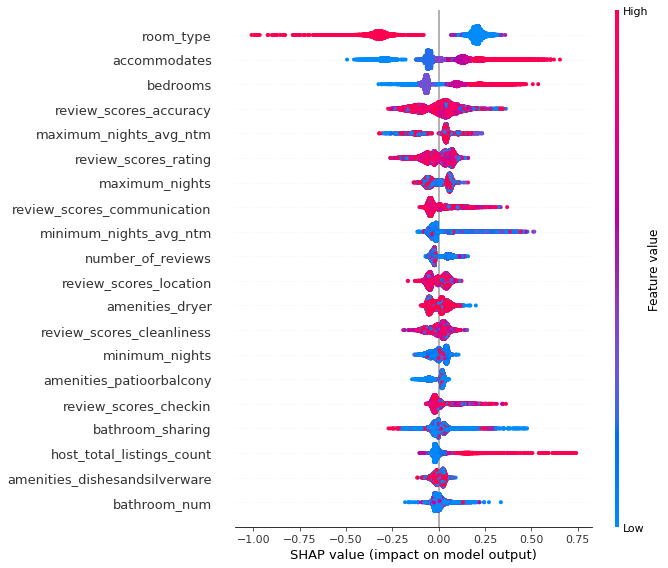

In [93]:
plt.figure(figsize = (8,5))
shap.summary_plot(shap_values, X_train)
plt.show()

### Neural Network SHAP

In [ ]:
explainer = shap.DeepExplainer(best_model_bl,X_train[:100])
shap_values = explainer.shap_values(X_train.values)
plt.figure(figsize = (8,5))
shap.summary_plot(shap_values, X_train, show=False)
plt.title("Baseline NN SHAP values",size=30)
plt.show()

In [ ]:
explainer = shap.DeepExplainer(best_model_dp,X_train[:100])
shap_values = explainer.shap_values(X_train.values)
plt.figure(figsize = (8,5))
shap.summary_plot(shap_values, X_train, show=False)
plt.title("Deep NN SHAP values",size=30)
plt.show()

In [ ]:
explainer = shap.DeepExplainer(best_model_wd,X_train[:100])
shap_values = explainer.shap_values(X_train.values)
plt.figure(figsize = (8,5))
shap.summary_plot(shap_values, X_train, show=False)
plt.title("Wide NN SHAP values",size=30)
plt.show()

### Actual vs Predicted

In [ ]:
import matplotlib.cm as cm
sns.set_style("whitegrid")

In [ ]:
stacking_regressor_best.fit(X_train, y_train)
pred = stacking_regressor_best.predict(X_test)
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('Stacking Regressor Predicted vs True Log Price', fontsize = 15)
plt.show()

In [ ]:
sns.histplot(df_pred['deviation'])
plt.xlabel('Error (Log Price)')
plt.ylabel('Number of Observations')
plt.title('Distribution of Prediction Error (Stacking)', fontsize = 15)
plt.xlim(-2, 2)
plt.show()

In [ ]:

lgbm_best.fit(X_train, y_train)
pred = lgbm_best.predict(X_test)
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('LGBM Predicted vs True Log Price', fontsize = 15)
plt.show()

In [ ]:
rf_best.fit(X_train, y_train)
pred = rf_best.predict(X_test)
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('Random Forest Predicted vs True Log Price', fontsize = 15)
plt.show()

In [ ]:
xgb_best.fit(X_train, y_train)
pred = xgb_best.predict(X_test)
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('XGBoost Predicted vs True Log Price', fontsize = 15)
plt.show()

### Neural Network Actual VS Predicted

In [ ]:
import matplotlib.cm as cm
sns.set_style("whitegrid")
import matplotlib.colors as mcolors

In [ ]:
pred = best_model_bl.predict(X_test_trfm)[:,0]
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('Baseline Neural Net Predicted vs True Log Price', fontsize = 15)
plt.show()

In [ ]:
sns.histplot(df_pred['deviation'])
plt.xlabel('Error (Log Price)')
plt.ylabel('Number of Observations')
plt.title('Distribution of Prediction Error (Baseline Neural Net)', fontsize = 15)
plt.xlim(-2, 2)
plt.show()

In [ ]:
pred = best_model_dp.predict(X_test_trfm)[:,0]
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('Deep Neural Net Predicted vs True Log Price', fontsize = 15)
plt.show()

In [ ]:
sns.histplot(df_pred['deviation'])
plt.xlabel('Error (Log Price)')
plt.ylabel('Number of Observations')
plt.title('Distribution of Prediction Error (Deep Neural Net)', fontsize = 15)
plt.xlim(-2, 2)
plt.show()

In [ ]:
pred = best_model_wd.predict(X_test_trfm)[:,0]
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('Wide Neural Net Predicted vs True Log Price', fontsize = 15)
plt.show()

In [ ]:
sns.histplot(df_pred['deviation'])
plt.xlabel('Error (Log Price)')
plt.ylabel('Number of Observations')
plt.title('Distribution of Prediction Error (Wide Neural Net)', fontsize = 15)
plt.xlim(-2, 2)
plt.show()